1. Data processing :
two files to be processes : temperature file and population file

In [1]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import pandas as pd
from importlib import reload
import functions as f
from tqdm import tqdm
import plotly.express as px
from PIL import Image

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
reload(f)

<module 'functions' from 'c:\\Users\\croge\\OneDrive\\Documents\\cours EPFL\\MA3\\ML_project\\UHI_prediction\\functions.py'>

In [2]:
#pop_day_europe = rio.open(r'data_population_day\ENACT_POP_D072011_EU28_R2020A_4326_30ss_V1_0.tif')
#pop_night_europe = rio.open(r'data_night_30ss\ENACT_POP_N072011_EU28_R2020A_4326_30ss_V1_0.tif')

land_cover = rio.open(r"MCD12Q1.061_LC_Prop1_doy2011001_aid0001.tif")

elevation1 = rio.open(r'elevation\30N000E_20101117_gmted_mea300.tif')
elevation2 = rio.open(r'elevation\30N030W_20101117_gmted_mea300.tif')
elevation3 = rio.open(r'elevation\50N000E_20101117_gmted_mea300.tif')
elevation4 = rio.open(r'elevation\50N030W_20101117_gmted_mea300.tif')

NDVI = xr.open_dataset(r'NDVI\c_gls_NDVI_201406110000_GLOBE_PROBAV_V2.2.1.nc')

vienna_tas = xr.open_dataset(r'data_cities\vienna_data\tas_Vienna_UrbClim_2011_08_v1.0.nc')

elev_list = [elevation1,elevation2,elevation3,elevation4]
folder = 'data_cities'

In [3]:
elevation = rio.open(r'elevation\elevation_merged.tif') 
cities = ['Amsterdam', 'Madrid', 'Stockholm', 'Lyon', 'Vienna']

In [4]:
reload(f)
#city_df = f.process_data(elevation, land_cover, NDVI, 40000, cities=cities)
city_df_interp = pd.read_csv('data_cities/city_df_interp.csv')
#city_df.to_csv('data_cities\city_df.csv')

In [ ]:
#city_df_interp = f.process_data(elevation, land_cover, NDVI, 40000, cities=cities, interpolation=True) #interpolation parameter chooses the method of upsampling
#city_df_interp.to_csv('data_cities\city_df_interp.csv')

In [5]:
latitudes = {'Amsterdam' : 52.377956, 'Madrid' : 40.416775, 'Stockholm' : 59.329323, 'Lyon' : 45.764043, 'Vienna' : 48.208174}
#add a column with the latitude of the city
city_df_interp['latitude'] = city_df_interp['city'].map(latitudes)
#remplace negative pop values with 0
city_df_interp['pop'] = city_df_interp['pop'].apply(lambda x: 0 if x < 0 else x)
city_df_interp.head()

,Unnamed: 0,temp,pop,wind,hum,deltaT,hour,month,elevation,city,land cover type,NDVI,isrural,latitude
0,0,276.45795,3335.140848,2.073505,86.510470,0.708160,0,1,0,Amsterdam,22,0.636830,NaN,52.377956
1,1,273.60233,401.735647,1.720720,89.044340,-0.409088,22,1,1,Amsterdam,18,0.705246,1.0,52.377956
2,2,278.21430,0.768097,4.584240,86.296180,0.209229,11,1,0,Amsterdam,31,0.827180,1.0,52.377956
3,3,274.55290,4.559323,1.749127,89.163864,-0.235565,7,1,0,Amsterdam,2,0.736148,1.0,52.377956
4,4,277.33792,0.000000,3.725439,89.338380,0.411987,10,1,-2,Amsterdam,31,0.908003,NaN,52.377956


In [6]:
city_df_interp.fillna(0, inplace=True)
city_df_interp.describe().loc[:,'pop']

count    2.215107e+06
mean     1.355835e+03
std      2.953738e+03
min      0.000000e+00
25%      4.944234e+00
50%      1.696503e+02
75%      1.207084e+03
max      3.562126e+04
Name: pop, dtype: float64

array([<Axes: title={'center': 'NDVI'}>], dtype=object)

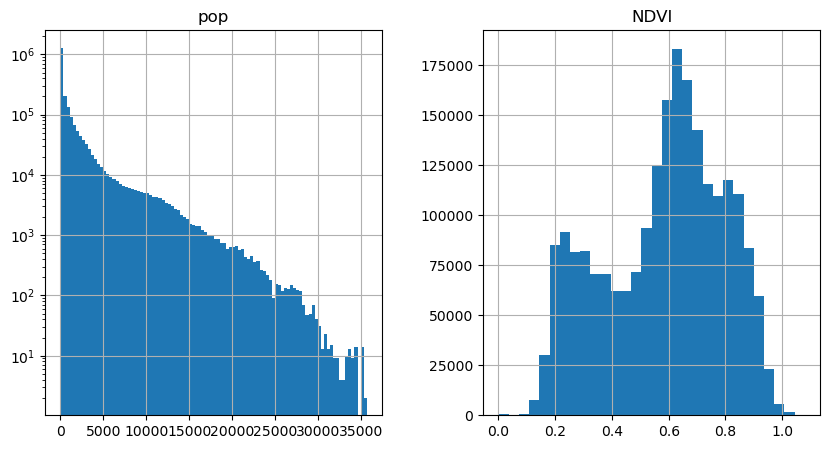

In [7]:
fig,axs = plt.subplots(1,2, figsize=(10,5))
city_df_interp.hist(column='pop', bins=100, log=True, ax=axs[0])
city_df_interp.hist(column='NDVI', bins=30, ax=axs[1])


Lets do some exploratory data analysis on the data first

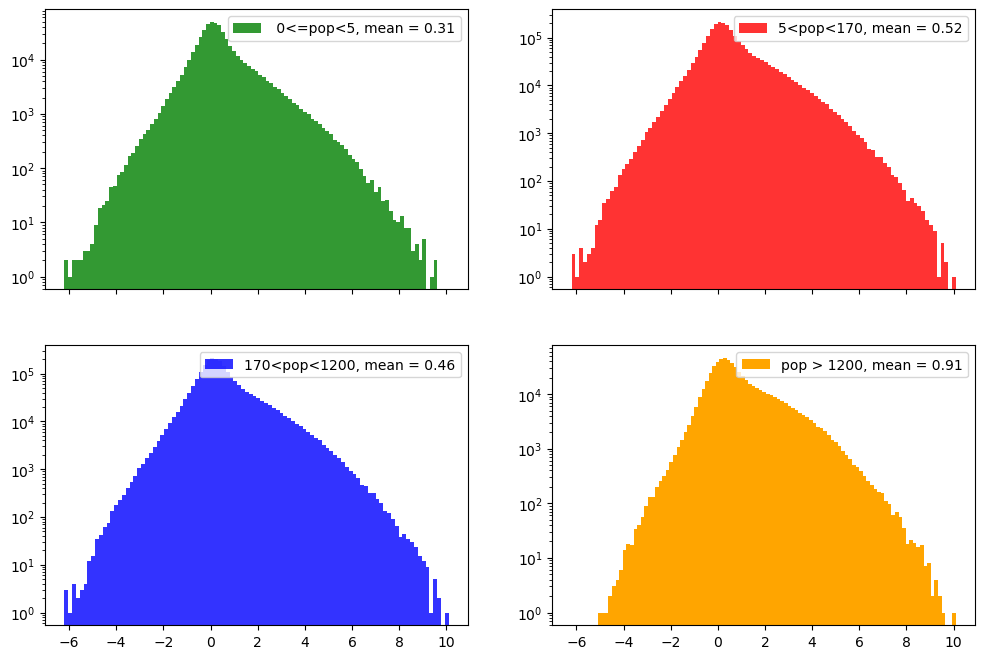

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)


axs[0,1].hist(city_df_interp[(city_df_interp['pop']>=2) & city_df_interp['pop']<115]['deltaT'], log=True, bins = 100, alpha = 0.8, color = 'red', label =  f'5<pop<170, mean = {np.mean(city_df_interp[(city_df_interp["pop"]>=2) & city_df_interp["pop"]<115]["deltaT"]):.2f}')
axs[0,1].legend()
axs[0,0].hist(city_df_interp[(city_df_interp["pop"]>=0) & (city_df_interp["pop"]<2)]["deltaT"], log=True, bins = 100, color = 'green', alpha = 0.8, label = f' 0<=pop<5, mean = {np.mean(city_df_interp[(city_df_interp["pop"]>0) & (city_df_interp["pop"]<2)]["deltaT"]):.2f}')
axs[0,0].legend()
axs[1,0].hist(city_df_interp[(city_df_interp['pop']>115) & city_df_interp['pop']<1083]['deltaT'], log=True, bins = 100, alpha = 0.8, color = 'blue', label =  f'170<pop<1200, mean = {np.mean(city_df_interp[(city_df_interp["pop"]>115) & (city_df_interp["pop"]<1083)]["deltaT"]):.2f}')
axs[1,0].legend()
axs[1,1].hist(city_df_interp[city_df_interp['pop']>1083]['deltaT'], log=True, bins = 100, alpha = 1, color = 'orange', label =  f'pop > 1200, mean = {np.mean(city_df_interp[city_df_interp["pop"]>1083]["deltaT"]):.2f}')
axs[1,1].legend()


plt.show()


In [9]:
city_df_interp['NDVI'].describe()

count    2.215107e+06
mean     5.814551e-01
std      2.113173e-01
min      0.000000e+00
25%      4.151078e-01
50%      6.147704e-01
75%      7.424576e-01
max      1.079634e+00
Name: NDVI, dtype: float64

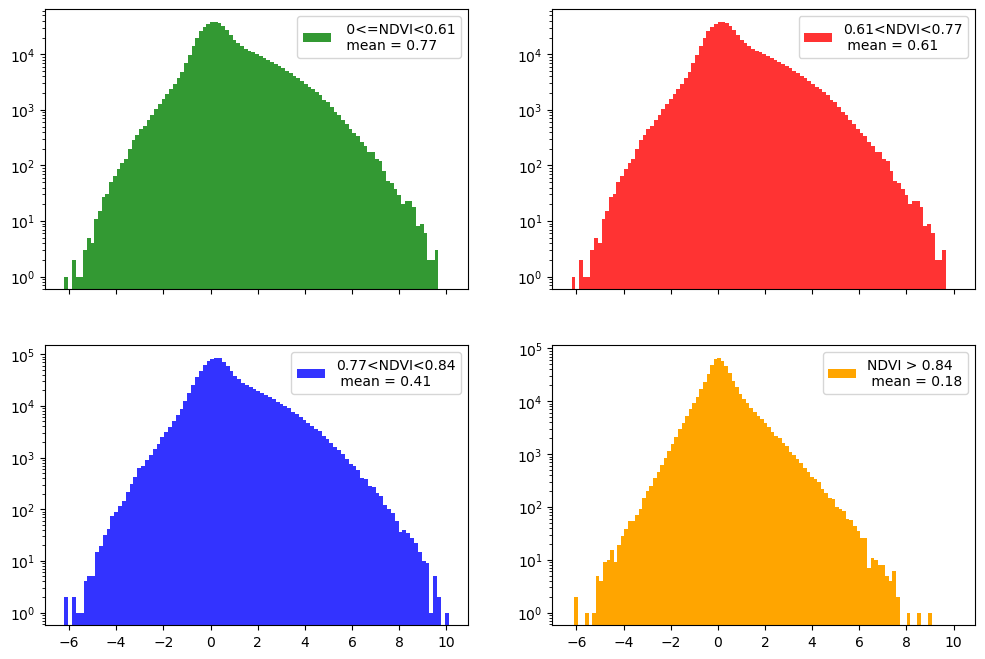

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)


axs[0,1].hist(city_df_interp[(city_df_interp['NDVI']>=0.41) & city_df_interp['NDVI']<0.61]['deltaT'], log=True, bins = 100, alpha = 0.8, color = 'red', label =  f'0.61<NDVI<0.77\n mean = {np.mean(city_df_interp[(city_df_interp["NDVI"]>=0.41) & city_df_interp["pop"]<0.61]["deltaT"]):.2f}')
axs[0,1].legend()
axs[0,0].hist(city_df_interp[(city_df_interp["pop"]>=0) & (city_df_interp["NDVI"]<0.41)]["deltaT"], log=True, bins = 100, color = 'green', alpha = 0.8, label = f' 0<=NDVI<0.61\n mean = {np.mean(city_df_interp[(city_df_interp["NDVI"]>0) & (city_df_interp["NDVI"]<0.41)]["deltaT"]):.2f}')
axs[0,0].legend()
axs[1,0].hist(city_df_interp[(city_df_interp['NDVI']>0.61) & city_df_interp['NDVI']<0.74]['deltaT'], log=True, bins = 100, alpha = 0.8, color = 'blue', label =  f'0.77<NDVI<0.84\n mean = {np.mean(city_df_interp[(city_df_interp["NDVI"]>0.61) & (city_df_interp["NDVI"]<0.74)]["deltaT"]):.2f}')
axs[1,0].legend()
axs[1,1].hist(city_df_interp[city_df_interp['NDVI']>=0.74]['deltaT'], log=True, bins = 100, alpha = 1, color = 'orange', label =  f'NDVI > 0.84\n mean = {np.mean(city_df_interp[city_df_interp["NDVI"]>=0.74]["deltaT"]):.2f}')
axs[1,1].legend()


plt.show()


Text(0.5, 1.0, 'Avg DeltaT vs NDVI')

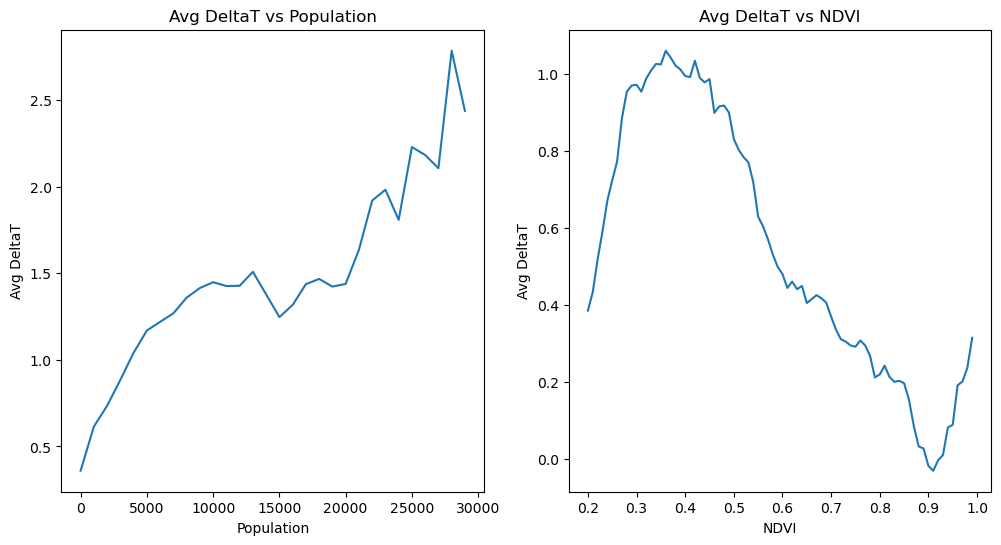

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
#create a list of tuples with population intervals
pop_intervals = [(i,i+1000) for i in range(0, 30000, 1000)]
#compute the avg detlaT for each population interval
deltaT_list = [np.mean(city_df_interp[(city_df_interp['pop']>i) & (city_df_interp['pop']<j)]['deltaT']) for i,j in pop_intervals]
#plot the avg deltaT for each population interval
axs[0].plot([i for i,j in pop_intervals], deltaT_list)
axs[0].set_xlabel('Population')
axs[0].set_ylabel('Avg DeltaT')
axs[0].set_title('Avg DeltaT vs Population')

#create a list of tuples with NDVI intervals (between 0 and 1)
NDVI_intervals = [(i/100, (i+1)/100) for i in range(20, 100)]
#compute the avg detlaT for each population interval
deltaT_list = [np.mean(city_df_interp[(city_df_interp['NDVI']>i) & (city_df_interp['NDVI']<j)]['deltaT']) for i,j in NDVI_intervals]
#plot the avg deltaT for each NDVIulation interval
axs[1].plot([i for i,j in NDVI_intervals], deltaT_list)
axs[1].set_xlabel('NDVI')
axs[1].set_ylabel('Avg DeltaT')
axs[1].set_title('Avg DeltaT vs NDVI')


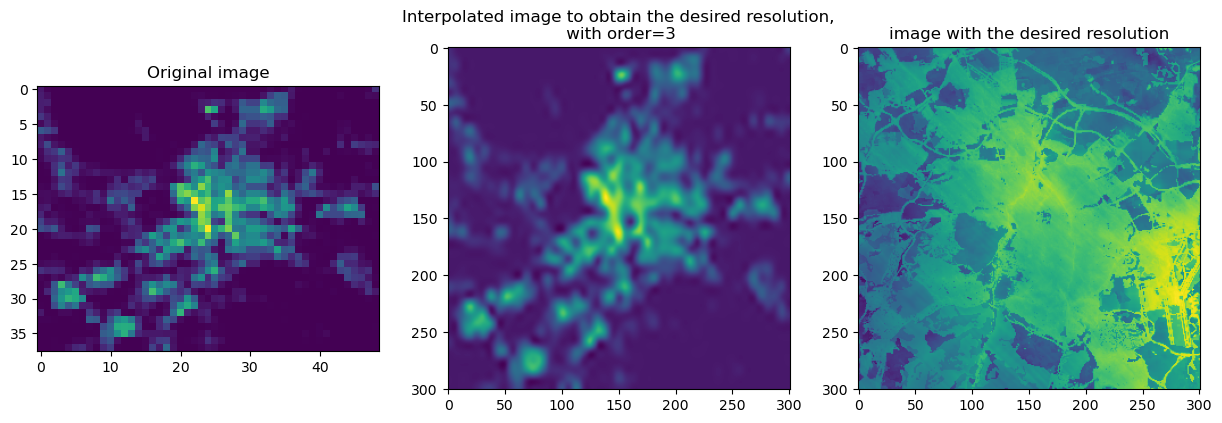

In [14]:
#method of interpolation

import numpy as np
import scipy.ndimage

temp_madrid = xr.open_dataset(r'data_cities\madrid_data\tas_Madrid_UrbClim_2011_09_v1.0.nc')
pop_day_m = rio.open(r'data_population_day\ENACT_POP_D092011_EU28_R2020A_4326_30ss_V1_0.tif')

pop_day_m = f.crop_image(pop_day_m, temp_madrid)
x = pop_day_m


#subplot of the original image and interpolated image
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(x)
axs[0].set_title('Original image')
axs[1].imshow(scipy.ndimage.zoom(x, (301/x.shape[0], 301/x.shape[1]), order=3))
axs[1].set_title('Interpolated image to obtain the desired resolution,\n with order=3')
axs[2].imshow(temp_madrid['tas'][0,:,:])
axs[2].set_title('image with the desired resolution')
plt.show()


In [15]:
#store the quartiles of the deltaT
q1 = city_df_interp['deltaT'].quantile(0.25)
q2 = city_df_interp['deltaT'].quantile(0.5)
q3 = city_df_interp['deltaT'].quantile(0.75)


In [16]:
#create a column with population category : 0 for pop<100, 2 for 100<pop<1000, 2 for 1000<pop<100000, 3 for pop>100000 and a deltaT category : 0 for deltaT<q1, 1 for q1<deltaT<q2, 2 for q2<deltaT<q3, 3 for deltaT>q3
city_df_interp['pop_cat'] = city_df_interp['pop'].apply(lambda x : 0 if x<100 else (1 if x<1000 else (2 if x<10000 else 3)))
city_df_interp['deltaT_cat'] = city_df_interp['deltaT'].apply(lambda x : 0 if x<=q1 else (1 if x<=q2 else (2 if x<=q3 else 3)))

In [17]:
city_df_interp.fillna(0, inplace=True) #replace NaN values by 0 (only happens for the isrural column)


In [18]:
#Linear regression using sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

city_df_test = city_df_interp[city_df_interp['city'] != 'Lyon'].sample(300000) #we choose a sample of 300000 rows to train the model, excluding Lyon

X = city_df_test[['pop', 'elevation', 'land cover type', 'hum', 'wind', 'hour','month', 'NDVI', 'pop_cat', 'temp', 'latitude', 'deltaT_cat']]
y = city_df_test['deltaT']

#standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X[['pop', 'elevation', 'hum', 'wind', 'NDVI', 'temp']] = scaler.fit_transform(X[['pop', 'elevation', 'hum', 'wind', 'NDVI', 'temp']])

#sample the data so that we have equal number of samples per category of deltaT

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['deltaT_cat'])



'''#sample the data to have equal data per category of population
X_sampled = pd.DataFrame(columns = X.columns)
for i in range(4):
    X_sampled = pd.concat([X_sampled, X_train[X_train['pop_cat']==i].sample(100000)])

indexes = X_sampled.index
y_sampled = y_train.loc[indexes]'''


"#sample the data to have equal data per category of population\nX_sampled = pd.DataFrame(columns = X.columns)\nfor i in range(4):\n    X_sampled = pd.concat([X_sampled, X_train[X_train['pop_cat']==i].sample(100000)])\n\nindexes = X_sampled.index\ny_sampled = y_train.loc[indexes]"

In [19]:
#check the cities
city_df_test['city'].unique()

array(['Madrid', 'Amsterdam', 'Vienna', 'Stockholm'], dtype=object)

# Multi-layer Perceptron regressor

MLP are a category of machine learning algorithm consisting in at least 3 layers of fully interconnected neurons. Learning occurs by changing the connection weights base on the error between the predicted and the actual output. The backpropagation algorithm is used to calculate the error and update the weights. The major disadvantage of MLP is that it is very computationally expensive to train. Here is a schema of an MLP regressor from Skiba (2020)
<p align="center">
  <img src="Example-of-multilayer-perceptron-MLP-network-for-regression-analysis-here-n-13-and.png" />
</p>


In [692]:
#Implement MLP regressor
from sklearn.neural_network import MLPRegressor


mlp = MLPRegressor(max_iter=500, hidden_layer_sizes=(100),
                    activation='relu', verbose=True, solver='adam',
                    alpha=0.0001, random_state=42, tol = 10e-5, learning_rate_init=0.001,
                    learning_rate='adaptive', warm_start=True, epsilon=0.001, early_stopping=True,
                    validation_fraction=0.1, n_iter_no_change=10,
                    )

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2 score: ', r2_score(y_test, y_pred))




Iteration 1, loss = 0.35971733
Validation score: 0.741318
Iteration 2, loss = 0.14950873
Validation score: 0.758739
Iteration 3, loss = 0.13756685
Validation score: 0.785475
Iteration 4, loss = 0.12948609
Validation score: 0.793113
Iteration 5, loss = 0.12453121
Validation score: 0.802688
Iteration 6, loss = 0.12101428
Validation score: 0.798014
Iteration 7, loss = 0.11904220
Validation score: 0.807561
Iteration 8, loss = 0.11703086
Validation score: 0.807760
Iteration 9, loss = 0.11533157
Validation score: 0.806781
Iteration 10, loss = 0.11510587
Validation score: 0.817032
Iteration 11, loss = 0.11348212
Validation score: 0.813251
Iteration 12, loss = 0.11287217
Validation score: 0.816625
Iteration 13, loss = 0.11233878
Validation score: 0.818293
Iteration 14, loss = 0.11178650
Validation score: 0.816531
Iteration 15, loss = 0.11098423
Validation score: 0.821794
Iteration 16, loss = 0.10981021
Validation score: 0.821522
Iteration 17, loss = 0.11018153
Validation score: 0.817479
Iterat

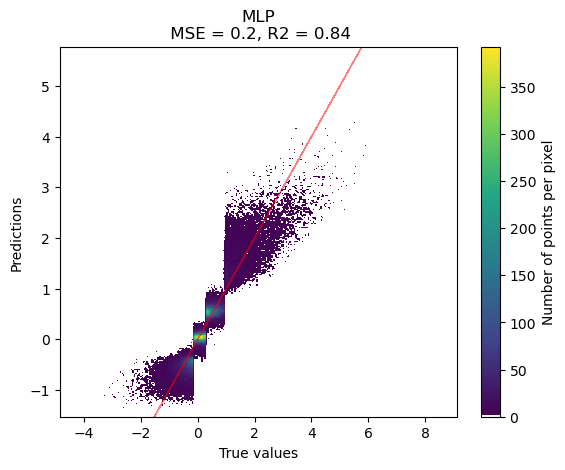

In [693]:
#plot the predictions vs the true values
fig = plt.figure()
f.using_mpl_scatter_density(fig, y_test, y_pred)
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.title(f'MLP\n MSE = {round(mean_squared_error(y_test, y_pred), 2)}, R2 = {round(r2_score(y_test, y_pred), 2)}')
plt.plot(y_test, y_test, color='red', linewidth=.5, alpha = 0.5)
fig.show()

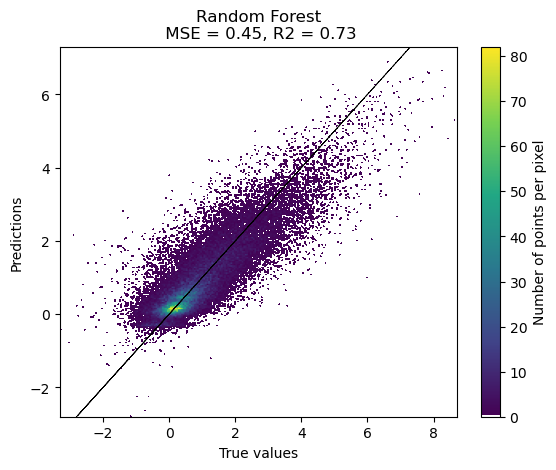

In [234]:
fig = plt.figure()
f.using_mpl_scatter_density(fig,y_test, y_pred)
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.title(f'Random Forest\n MSE = {round(mean_squared_error(y_test, y_pred), 2)}, R2 = {round(r2_score(y_test, y_pred), 2)}')
plt.plot(y_test, y_test, color='black', linewidth=.5, linestyle='dashed')
plt.show()

In [236]:
#extra trees
from sklearn.ensemble import ExtraTreesRegressor

cv = ExtraTreesRegressor(random_state=42, n_jobs=1, n_estimators=10, max_depth=20, min_samples_split=2, max_features=10, verbose=2)

cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))




building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
MSE:  0.43264845728696805
R2:  0.7366200168963795


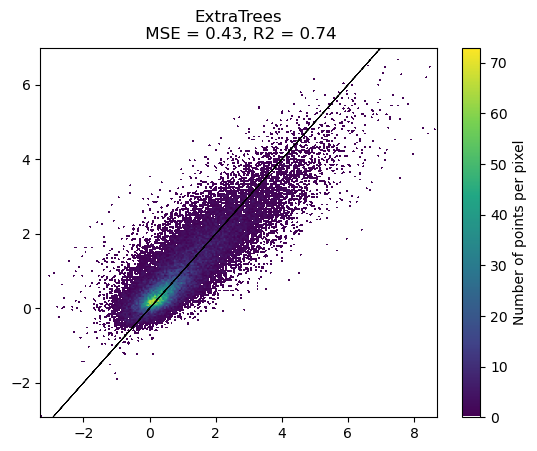

In [237]:
#print variance and bias
fig = plt.figure()
f.using_mpl_scatter_density(fig,y_test, y_pred)
plt.plot(y_test, y_test, color='black', linewidth=.5, linestyle='dashed')
plt.title(f'ExtraTrees\n MSE = {round(mean_squared_error(y_test, y_pred), 2)}, R2 = {round(r2_score(y_test, y_pred), 2)}')
plt.show()

# Gradient Boosting regressor

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. The sklearn histGradientBoostingRegressor is based on the LightGBM method that uses an histogram based method to bin the features, therefore using less memory and being faster than the classical gradient boosting method. Here is a schema of the gradient boosting algorithm.
<p align="center">
  <img src="Flow-diagram-of-gradient-boosting-machine-learning-method-The-ensemble-classifiers.png" />
</p>


Binning 0.021 GB of training data: 

  File "c:\Users\croge\anaconda3\envs\ML\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


0.646 s
Binning 0.002 GB of validation data: 0.008 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 31 leaves, max depth = 6, train loss: 0.51172, val loss: 0.51283, in 0.067s
[2/1000] 1 tree, 31 leaves, max depth = 6, train loss: 0.43591, val loss: 0.43676, in 0.042s
[3/1000] 1 tree, 31 leaves, max depth = 6, train loss: 0.37440, val loss: 0.37508, in 0.055s
[4/1000] 1 tree, 31 leaves, max depth = 6, train loss: 0.32481, val loss: 0.32541, in 0.038s
[5/1000] 1 tree, 31 leaves, max depth = 6, train loss: 0.28378, val loss: 0.28457, in 0.028s
[6/1000] 1 tree, 31 leaves, max depth = 6, train loss: 0.25051, val loss: 0.25116, in 0.028s
[7/1000] 1 tree, 31 leaves, max depth = 6, train loss: 0.22346, val loss: 0.22424, in 0.027s
[8/1000] 1 tree, 31 leaves, max depth = 6, train loss: 0.20109, val loss: 0.20180, in 0.029s
[9/1000] 1 tree, 31 leaves, max depth = 6, train loss: 0.18324, val loss: 0.18395, in 0.043s
[10/1000] 1 tree, 31 leaves, max depth = 6, train loss: 0.16830, val loss: 0.

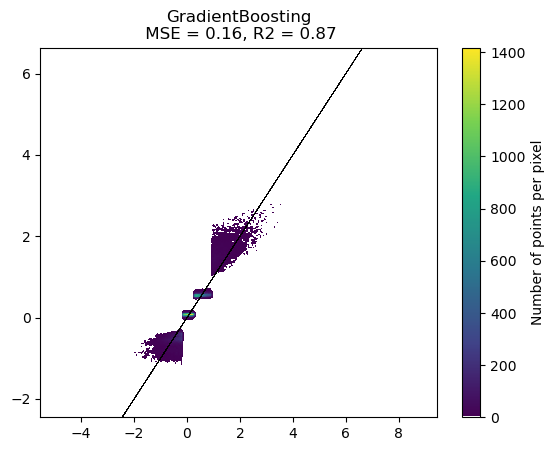

In [20]:
#Gradient boosting
from sklearn.ensemble import HistGradientBoostingRegressor

model = HistGradientBoostingRegressor(random_state=42, max_depth=6, learning_rate=0.1, min_samples_leaf=2, max_iter=1000, verbose=2, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, tol=10e-4)    


model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))

fig = plt.figure()
f.using_mpl_scatter_density(fig, y_test, y_pred)
plt.title(f'GradientBoosting\n MSE = {round(mean_squared_error(y_test, y_pred), 2)}, R2 = {round(r2_score(y_test, y_pred), 2)}')
plt.plot(y_test, y_test, color='black', linestyle='dashed', linewidth=.2)

In [21]:
model_final = model
print(model_final.predict(X_test.iloc[143:145]))
print(y_test.iloc[143:145].values)

[0.48962443 0.07768499]
[ 0.28302002 -0.09793091]


In [22]:
#export the model
import pickle
filename = 'finalized_model.sav'
pickle.dump(model_final, open(filename, 'wb'))


Number of nan values in deltaT:  2068
Number of nan values in deltaT_predicted:  2068


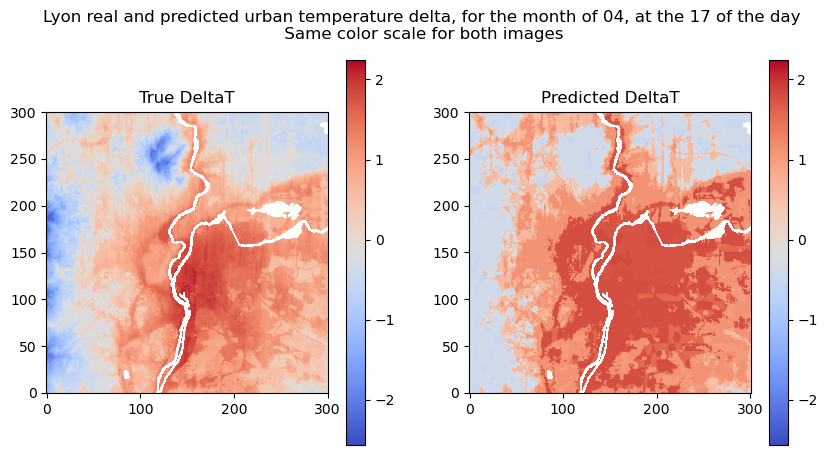

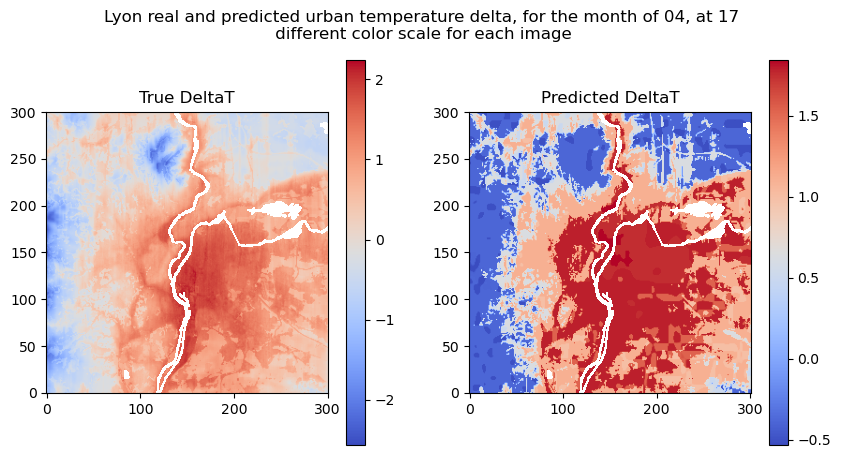

In [23]:
#visualize the prediction for a city, month and given hour (not in the training set)
f.visualization_prediction('Lyon', 24*24+17, model_final, 4, [q1, q2, q3], cmap = 'coolwarm')

Number of nan values in deltaT:  2044
Number of nan values in deltaT_predicted:  2044


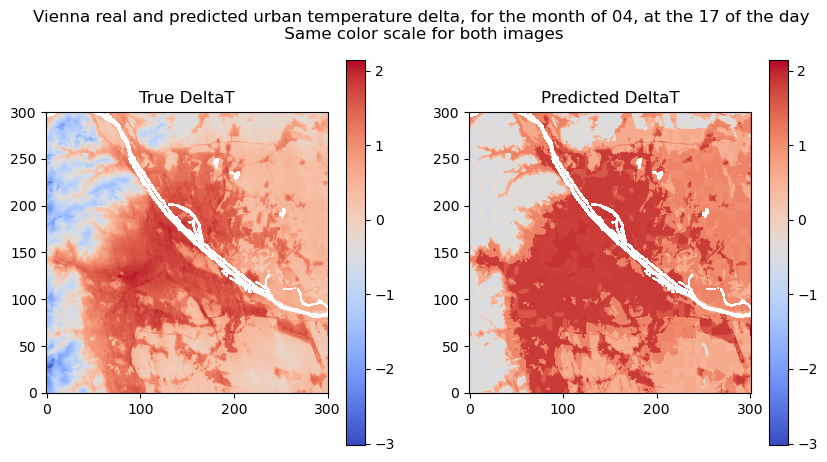

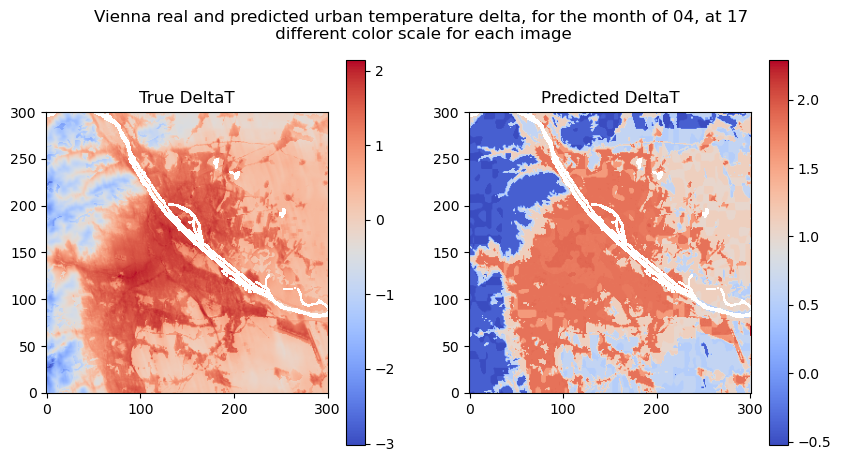

In [24]:
#visualize the prediction for a city, month and given hour (in the training set)
f.visualization_prediction('Vienna', 24*24+17, model_final, 4, [q1, q2, q3], cmap = 'coolwarm')